-Embed dataset
-Target: B/M

In [1]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms, utils
import glob
import random 
import SimpleITK as sitk
import torch.nn.functional as F


In [2]:
# rescale img by min and max
def rescale_img(img): 
    rescaler = sitk.RescaleIntensityImageFilter()
    return rescaler.Execute(img)
    
class Embed_data(Dataset):

    def __init__(self, csv_file, transform0=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.            
            transform: transform to be applied on a sample.
        """
        self.info = pd.read_csv(csv_file)
        self.transform0 = transform0        
        
        self.targets = F.one_hot(torch.tensor(list(pd.read_csv(csv_file)['cancer'])))
        
    def __len__(self):
        return len(self.info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()            

        img_path0 = self.info['new_path'][idx]        
        image0 = sitk.ReadImage(img_path0, sitk.sitkFloat32) #sitk.sitkUInt32)        
        #image0 = rescale_img(image0)
        
        im_arr0 = sitk.GetArrayFromImage(image0)
        #print(im_arr0)
        im_arr0 = im_arr0 + abs(im_arr0.min())
        #print(im_arr0.min(), im_arr0.max())
        im_arr0 = im_arr0 / im_arr0.max()
        im_tsr0 = torch.from_numpy(np.expand_dims(im_arr0, axis=0))
        lbls = self.targets[idx]     

        if self.transform0 :
            im_tsr0 = self.transform0(im_tsr0)     
                       
        else:
            im_tsr0 = im_tsr0            
            
        return im_tsr0.float(), lbls

In [3]:
train_transform0 = transforms.Compose([
    transforms.Resize((256,256))])

test_transform = transforms.Compose([
    transforms.Resize(size=(256,256))])

0 (1, 256, 256)
label:  tensor([1, 0])


/home/jupyter-li/.conda/envs/torch_2.0.1/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


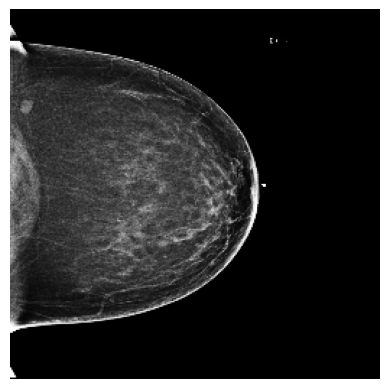

1 (1, 256, 256)
label:  tensor([1, 0])


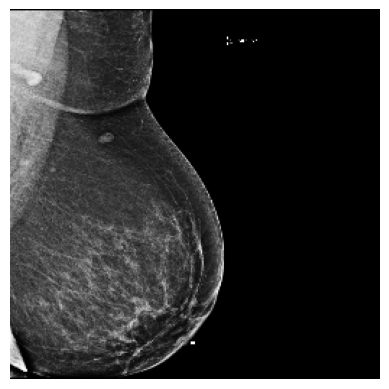

2 (1, 256, 256)
label:  tensor([1, 0])


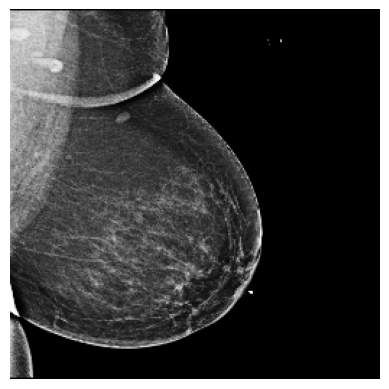

3 (1, 256, 256)
label:  tensor([1, 0])


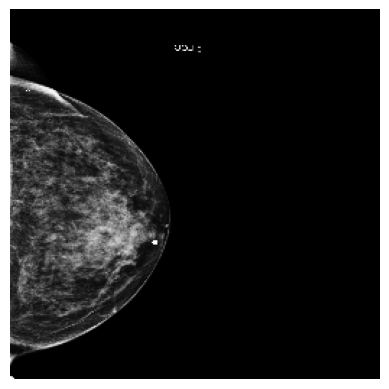

4 (1, 256, 256)
label:  tensor([1, 0])


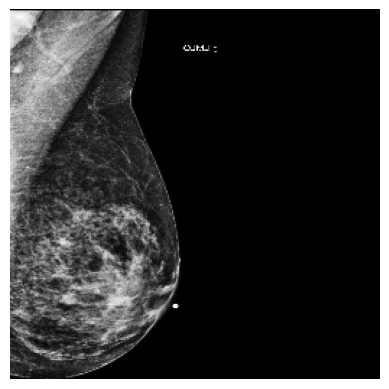

5 (1, 256, 256)
label:  tensor([1, 0])


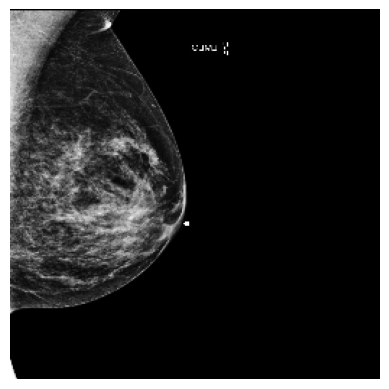

In [4]:
## show images

Embed_dataset = Embed_data(csv_file='./label.csv', transform0=train_transform0)

def show_images(image, labels):
    """Show image and label"""        
    plt.imshow(np.squeeze((image).numpy()), cmap='gray')
    plt.axis('off')
    print('label: ',labels)
    plt.pause(0.001) 

fig = plt.figure()

for i in range(len(Embed_dataset)):
    im0, lbl = Embed_dataset[i]

    print(i, (im0.numpy()).shape)
    show_images(im0, lbl)

    if i == 5:
        plt.show()
        break

In [5]:
import torch.nn as nn
from torchvision.models.resnet import resnet18
from torchvision.models import ResNet18_Weights
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
        
        self.model.fc = nn.Sequential(nn.Linear(512, 2), nn.Softmax(dim=1))
                
    def forward(self, x):
        x = self.model(x) 
        
        return x    

In [7]:
# train for one epoch to learn unique features
def train(net, data_loader, train_optimizer, device):
    net.train()
    total_loss, total_acc_cla, total_num, train_bar = 0.0, 0.0, 0, tqdm(data_loader)
   
    for pos_1, target in train_bar:
        pos_1, target = pos_1.to(device), target.to(device)
        #print(len(pos_1), len(target))
        cla1 = net(pos_1)
        #print(cla1.shape, target.shape)
        # Class loss
        Cla_loss = nn.CrossEntropyLoss()
        loss = Cla_loss(cla1, target.float())
        
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += pos_1.size(0)
        total_loss += loss.item() * pos_1.size(0)
        
        # labels predicted by the classifier          
        pred_labels_cla1 = torch.argmax(cla1.round(), dim=1).unsqueeze(dim=-1)
        aa = torch.sum((pred_labels_cla1 == torch.argmax(target, dim=1).unsqueeze(dim=-1)).any(dim=-1).float()).item()    
        total_acc_cla += aa
        
        train_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f} ACC: {:.2f}%'.format(epoch, epochs, total_loss/total_num, total_acc_cla/total_num*100))
        
    return total_loss / total_num, total_acc_cla / total_num*100

In [8]:
def validate(net, data_loader):
    net.eval()
    with torch.no_grad():
        total_loss, total_acc_cla, total_num, val_bar = 0.0, 0.0, 0, tqdm(data_loader)
        y_pred = []
        y_true = []
        i = 0
        for pos_1, target in val_bar:
            pos_1, target = pos_1.to(device), target.to(device)            
            cla1 = net(pos_1)

            # Class loss
            Cla_loss = nn.CrossEntropyLoss()
            loss = Cla_loss(cla1, target.float())

            total_num += pos_1.size(0)
            total_loss += loss.item() * pos_1.size(0)
            
            # labels predicted by the classifier                       
            pred_labels_cla1 = torch.argmax(cla1.round(), dim=1).unsqueeze(dim=-1)
            target_temp = torch.argmax(target, dim=1).unsqueeze(dim=-1)
            aa = torch.sum((pred_labels_cla1 == target_temp).any(dim=-1).float()).item()    
            total_acc_cla += aa 
            
            #store the labels
            y_pred.append(pred_labels_cla1.cpu().detach().numpy().squeeze())
            y_true.append(target_temp.cpu().detach().numpy().squeeze())
            
            # calculate AUC for showing
            y_true_temp = np.concatenate(y_true)
            y_pred_temp = np.concatenate(y_pred)
           
            if i>=3:
                val_auc_temp = roc_auc_score(y_true_temp, y_pred_temp) 
                acc_test = np.sum((y_true_temp.round()==y_pred_temp.round()).astype(int))/y_true_temp.shape[0]
            else:
                acc_test = 0.0
                val_auc_temp = 0.0
            i += 1
            val_bar.set_description('Validation Epoch: [{}/{}] Loss: {:.4f} ACC: {:.2f}% AUC: {:.2f} ACC2: {:.2f}%'.format(epoch, epochs, total_loss/total_num, total_acc_cla/total_num*100, val_auc_temp, acc_test*100))
        
        # calculate AUC
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        val_auc_mean =  roc_auc_score(y_true, y_pred) 
        
    return total_loss / total_num, total_acc_cla/total_num*100, val_auc_mean

In [9]:
# Parameters
batch_size = 512 #Number of images in each mini-batch
epochs = 30 #Number of sweeps over the dataset to train
kfold = 5 # for cross-validation
lr = 5e-4

In [10]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

splits = KFold(n_splits=kfold, shuffle=True, random_state=56)

dataset = Embed_data(csv_file='./label.csv', transform0=train_transform0)

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))
    
    # Shuffle indexes
    np.random.shuffle(train_idx)
    
    # data prepare
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)    
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, drop_last=True)     
    
    # model setup and optimizer config

    #model = nn.DataParallel(Model())
    model = Model()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)     
    scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

    # training loop
    results = { 'val_loss': [], 'val_acc':[], 'val_auc':[], 'lr':[]}
    
    if not os.path.exists('results'):
        os.mkdir('results')
        
    best_acc = 0.0
    best_loss = 999.0
    for epoch in range(1, epochs + 1):
        _, _ = train(model, train_loader, optimizer, device)
        #train_loss, train_acc, train_auc = train_eval(model, eval_loader)
        #results['train_loss'].append(train_loss)
        #results['train_acc'].append(train_acc)
        #results['train_auc'].append(train_auc)
        val_loss, val_acc, val_auc = validate(model, val_loader)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)
        results['val_auc'].append(val_auc)
        #knn_acc = eval_sim(model, memory_loader, test_loader)
        #results['knn_acc'].append(knn_acc)
        results['lr'].append(get_lr(optimizer))
        
        scheduler1.step(val_loss)
        
        # save statistics
        data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
        data_frame.to_csv('results/{}epochs_fold{}-{}_statistics.csv'.format(epochs, kfold, fold+1), index_label='epoch')
        
        if (val_acc >= best_acc) and (val_loss <= best_loss):
            best_acc = val_acc
            best_loss = val_loss
            torch.save(model.state_dict(), 'results/epoch{}-{}_fold{}-{}_model.pth'.format(epochs, epoch, kfold, fold+1))
            
       
    # save the last model
    torch.save(model.state_dict(), 'results/epoch{}-{}_fold{}-{}_model.pth'.format(epochs, epoch, kfold, fold+1))
    

Fold 1


  0%|          | 0/56 [00:00<?, ?it/s]/home/jupyter-li/.conda/envs/torch_2.0.1/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Train Epoch: [1/30] Loss: 0.6194 ACC: 67.41%:  29%|██▊       | 16/56 [44:08<1:50:20, 165.52s/it]


KeyboardInterrupt: 

In [ ]:
# Parameters
batch_size = 32 #Number of images in each mini-batch
epochs = 20 #Number of sweeps over the dataset to train
lr = 2.5e-4

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = CXR_data(csv_file='./labels_prototyping.csv', transform0=train_transform0)

train_loader = DataLoader(dataset, batch_size=batch_size, drop_last=True)    
val_loader = DataLoader(dataset, batch_size=batch_size, drop_last=True)     

# model setup and optimizer config

#model = nn.DataParallel(Model())
model = Model()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)     
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

# training loop
results = { 'val_loss': [], 'val_acc':[], 'val_auc':[], 'lr':[]}

if not os.path.exists('results'):
    os.mkdir('results')

best_acc = 0.0
best_loss = 999.0
for epoch in range(1, epochs + 1):
    _, _ = train(model, train_loader, optimizer, device)
    #train_loss, train_acc, train_auc = train_eval(model, eval_loader)
    #results['train_loss'].append(train_loss)
    #results['train_acc'].append(train_acc)
    #results['train_auc'].append(train_auc)
    val_loss, val_acc, val_auc = validate(model, val_loader)
    results['val_loss'].append(val_loss)
    results['val_acc'].append(val_acc)
    results['val_auc'].append(val_auc)
    #knn_acc = eval_sim(model, memory_loader, test_loader)
    #results['knn_acc'].append(knn_acc)
    results['lr'].append(get_lr(optimizer))

    scheduler1.step(val_loss)

    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(1, epoch + 1))
    data_frame.to_csv('results/{}epochs_fold{}-{}_statistics.csv'.format(epochs, kfold, fold+1), index_label='epoch')

    if (val_acc >= best_acc) and (val_loss <= best_loss):
        best_acc = val_acc
        best_loss = val_loss
        torch.save(model.state_dict(), 'results/epoch{}-{}_fold{}-{}_model.pth'.format(epochs, epoch, kfold, fold+1))


# save the last model
torch.save(model.state_dict(), 'results/epoch{}-{}_fold{}-{}_model.pth'.format(epochs, epoch, kfold, fold+1))
    

In [17]:
test_data =  CXR_data(csv_file='./labels_test.csv', transform0=train_transform0)
test_loader = DataLoader(test_data, batch_size=2, drop_last=True)     

In [18]:
validate(model, test_loader)

Validation Epoch: [20/20] Loss: 0.3974 ACC: 91.09% AUC: 0.91 ACC2: 91.09%: 100%|██████████| 16159/16159 [44:28<00:00,  6.05it/s]


(0.3974115148217115, 91.08855746023887, 0.9085043498128427)

In [13]:
from torchsummary import summary

model = Model().cuda()   
summary(model, (1, 256, 256))